In [1]:
import numpy as np
import os 
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, add
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.utils import plot_model
from glob import glob
import cv2
from IPython.display import clear_output
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

class SRCNN():
  def __init__(self, lr_height, lr_width):
    self.channels = 3
    self.lr_height = lr_height
    self.lr_width = lr_width
    self.lr_shape = (self.lr_height, self.lr_width, self.channels)
    self.hr_height = self.lr_height*4   # High resolution height
    self.hr_width = self.lr_width*4     # High resolution width
    self.hr_shape = (self.hr_height, self.hr_width, self.channels)
    
  def CNN_module(self, input_layer, filters = 64, kernel_num = 3, is_activate = True ):
    #padding = 'same' ensures output size = input size
    #use_bias ensures bias layer
    d = Conv2D(filters, kernel_size = kernel_num, strides = 1, padding ='same'\
        , use_bias = True)(input_layer)
    d = BatchNormalization(momentum=0.5)(d)    
    if (is_activate):
      d = PReLU()(d)
      d = Dropout(rate = 0.8)(d)
    
    return d
  
  
  def build_model(self):
    input_layer = Input(shape = self.lr_shape)

    filter_sets = []

    filter_set1 = self.CNN_module(input_layer, 96, 3)
    filter_sets.append(filter_set1)

    filter_set2 = self.CNN_module(filter_set1, 76, 3)
    filter_sets.append(filter_set2)

    filter_set3 = self.CNN_module(filter_set2, 65, 3)
    filter_sets.append(filter_set3)

    filter_set4 = self.CNN_module(filter_set3, 55, 3)
    filter_sets.append(filter_set4)

    filter_set5 = self.CNN_module(filter_set4, 47, 3)
    filter_sets.append(filter_set5)

    filter_set6 = self.CNN_module(filter_set5, 39, 3)
    filter_sets.append(filter_set6)

    filter_set7 = self.CNN_module(filter_set6, 32, 3)
    filter_sets.append(filter_set7)

    filter_set8 = self.CNN_module(filter_set7, 32, 3)
    filter_sets.append(filter_set8)

    concat1 = concatenate(filter_sets)

    rec_a1 = self.CNN_module(concat1, 64, 1)

    rec_b1 = self.CNN_module(concat1, 32, 1)

    rec_b2 = self.CNN_module(rec_b1, 32, 3)

    concat2 = concatenate([rec_a1, rec_b2])

    L = self.CNN_module(concat2, 4, 1, False)

    conv_trans1 = Conv2DTranspose(3,kernel_size=4, strides= (4,4))(L)

    #upsample1 = UpSampling2D(interpolation = 'bilinear')(input_layer)
    #upsample2 = UpSampling2D(interpolation = 'bilinear')(upsample1)

    def upscale_func(x):
      return tf.image.resize(x, tf.constant([self.hr_height, self.hr_width]), method = 'bicubic')

    
    upsample2 = Lambda(upscale_func)(input_layer)

    Final = add([upsample2, conv_trans1])
    
    Final_Model = Model(input_layer, Final)

    #Final_Model.summary()

    #plot_model(Final_Model, to_file='/content/drive/My Drive/Colab Notebooks/model.png')

    return Final_Model


    

  def data_load(self, lr_folder, hr_folder):
      
    imgs_hr = []
    imgs_lr = []

    lr_path =  glob('%s/*' % (lr_folder))
    hr_path =  glob('%s/*' % (hr_folder))
    for i , (img_path1, img_path2) in enumerate(zip(lr_path, hr_path)):
      if(i < 500):
        clear_output()
        print(i)

        img = cv2.imread(img_path1)
        img = cv2.resize(img,(self.lr_width, self.lr_height))
        imgs_lr.append(img)

        img2 = cv2.imread(img_path2)
        img2 = cv2.resize(img2,(self.hr_width, self.hr_height))
        imgs_hr.append(img2)
    
    #print(img.shape)
    #print(img2.shape)

    imgs_hr = np.array(imgs_hr) / 127.5 - 1.
    imgs_lr = np.array(imgs_lr) / 127.5 - 1.      

    return imgs_lr, imgs_hr

def myGenerator(train_generator,train_generator1):

    while True:

        xy = train_generator.next() #or next(train_generator)
        xy1 = train_generator1.next() #or next(train_generator1)
        yield (xy[0],xy1[0])

if __name__ == '__main__':
    lr_height = 180
    lr_width = 256
    cnn = SRCNN(lr_height, lr_width)
    
    lr_small = '/content/drive/My Drive/SRGAN Datasets/Small_LR/'
    hr_small = '/content/drive/My Drive/SRGAN Datasets/Small_HR/'

    lr_folder = '/content/drive/My Drive/SRGAN Datasets/DIV2K_train_LR_unknown/'
    hr_folder = '/content/drive/My Drive/SRGAN Datasets/DIV2K_train_HR_unknown/'
    #X, y = cnn.data_load(lr_folder, hr_folder)


    #data_gen_args = dict(  rotation_range = 90., width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, rescale = 1./255,
    #                     horizontal_flip = True, fill_mode = 'wrap', validation_split = 0.1)

    data_gen_args = dict(   rescale = 1./255, horizontal_flip = True, fill_mode = 'wrap', validation_split = 0.1)
    
    X_datagen = ImageDataGenerator(**data_gen_args)
    y_datagen = ImageDataGenerator(**data_gen_args)

    #X_generator = X_datagen.flow(X,   batch_size= 1, seed=1)
    #y_generator = y_datagen.flow(y, batch_size= 1,seed=1)

    X_generator = X_datagen.flow_from_directory(lr_small, target_size = (lr_height,lr_width), #
                                                batch_size = 10, class_mode = 'input', seed = 1, subset='training' )

    y_generator = y_datagen.flow_from_directory(hr_small, target_size = (lr_height * 4, lr_width * 4), 
                                                batch_size = 10, class_mode = 'input', seed = 1, subset='training' )
    
    X_valid_generator = X_datagen.flow_from_directory(lr_small, target_size = (lr_height,lr_width), #
                                                batch_size = 10, class_mode = 'input', seed = 1, subset='validation' )
    
    y_valid_generator = y_datagen.flow_from_directory(hr_small, target_size = (lr_height * 4, lr_width * 4), 
                                                batch_size = 10, class_mode = 'input', seed = 1, subset='validation' )
    


    train_generator = myGenerator(X_generator,y_generator)
    test_generator = myGenerator(X_valid_generator, y_valid_generator)




    
    


Using TensorFlow backend.


Found 720 images belonging to 1 classes.
Found 720 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


In [0]:
import tensorflow as tf

def psnr_metric(a,b):
  return tf.image.psnr(a, b, max_val = 255, name=None)

cnn_model = cnn.build_model()
my_opt = Adam()
cnn_model.compile(optimizer = my_opt, loss= 'mse', metrics = [psnr_metric])
#cnn_model.summary()

In [0]:
history = cnn_model.fit_generator(train_generator,  steps_per_epoch=50, epochs=100,  verbose = 1, 
                                  validation_data = test_generator, validation_steps = 10, validation_freq = 1)
#history = cnn_model.fit(X, y, batch_size = 1, epochs=100,  verbose = 1, validation_split = 0.1)

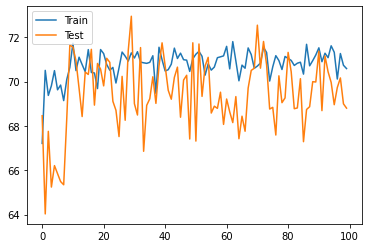

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['psnr_metric'])
plt.plot(history.history['val_psnr_metric'])
plt.legend(['Train', 'Test'], loc='upper left')